In [1]:
import numpy as np
from collections import defaultdict
import random
from tqdm import trange
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys
import igraph
from matplotlib import cm, colors
random.seed(42)
import seaborn as sns
from testing_environments import ContinuousTMaze, GridEnvRightDownNoCue, GridEnvRightDownNoSelf, GridEnvDivergingMultipleReward, GridEnvDivergingSingleReward
from util import *

In [34]:
 
# def generate_dataset(env, n_episodes=10, max_steps=20):
#     """
#     Run 'n_episodes' episodes in the environment. Each episode ends
#     either when the environment signals 'done' or when we hit 'max_steps'.

#     Returns:
#         A list of (state_sequence, action_sequence) pairs.
#         - state_sequence: list of visited states
#         - action_sequence: list of chosen actions
#     """
#     dataset = []

#     for episode_idx in range(n_episodes):
#         # Prepare lists to store states & actions for this episode
#         states = []
#         actions = []

#         # Reset env to start a new episode
#         state = env.reset()

#         for t in range(max_steps):
#             states.append(state)

#             valid_actions = env.get_valid_actions(state)
#             if not valid_actions:
#                 # No valid actions => we must be in a terminal or stuck
#                 break

#             # Example: pick a random valid action
#             action = np.random.choice(valid_actions)
#             actions.append(action)

#             # Step in the environment
#             next_state, reward, done = env.step(action)
#             state = next_state

#             if done:
#                 # Also record the final state
#                 states.append(state)

#                 # if state == 16:
#                 #     print(f"rewarded path: {states}")
#                 break
                
#         # Store (states, actions) for this episode
#         if done: # only append datasets that reached terminal state
#             dataset.append([states, actions])

#     return dataset

# def TM(dataset):
#     """
#     Given a dataset of episodes, each episode being (states_seq, actions_seq),
#     build a 3D count matrix of shape [max_state+1, max_action+1, max_state+1].
    
#     Returns:
#         transition_counts (np.ndarray): counts[s, a, s_next]
#             The number of times we observed (state=s) --(action=a)--> (next_state=s_next).
#     """
#     # 1) Collect all observed states and actions to determine indexing bounds
#     all_states = set()
#     all_actions = set()
    
#     for states_seq, actions_seq in dataset:
#         for s in states_seq:
#             all_states.add(s)
#         for a in actions_seq:
#             all_actions.add(a)
    
#     max_state = max(all_states) if all_states else 0
#     max_action = max(all_actions) if all_actions else 0
    
#     # 2) Initialize a 3D count array
#     #    We'll assume states range from 0..max_state
#     #    and actions range from 0..max_action
#     transition_counts = np.zeros((max_state+1, max_action+1, max_state+1), dtype=int)
    
#     # 3) Fill in the counts by iterating over each episode's transitions
#     for states_seq, actions_seq in dataset:
#         # for each step t in the episode
#         # print(len(states_seq), len(actions_seq))
#         for t in range(len(actions_seq)):
#             s = states_seq[t]
#             a = actions_seq[t]
#             s_next = states_seq[t+1]
#             transition_counts[s, a, s_next] += 1
    
#     return transition_counts

# def successor_representations(dataset, gamma=0.9, alpha=0.1, n_states=None, n_passes=1):
#     """
#     Learns the successor representation M via a TD-like update on raw trajectories:
#         M[s, :] <- M[s, :] + alpha * ( e_s + gamma*M[s_next, :] - M[s, :] ).
    
#     Parameters
#     ----------
#     states : list or np.ndarray
#         Sequence of states visited (s_0, s_1, ..., s_T). 
#     gamma : float
#         Discount factor.
#     alpha : float
#         Learning rate.
#     n_states : int
#         Total number of discrete states. If None, we'll infer from max state in 'states'.
#     n_passes : int
#         Number of passes (epochs) over the entire dataset to refine the estimate.

#     Returns
#     -------
#     M : np.ndarray of shape (n_states, n_states)
#         Learned SR matrix.
#     """
#     if n_states is None:
#         # n_states = int(np.max(states))  # infer if states are 0-based
#         # n_states = max(max(state) for state in states)
#         n_states = max(max(pair[0]) for pair in dataset) + 1

#     # Initialize
#     M = np.zeros((n_states, n_states))
    
#     # for _ in range(n_passes):
#     for states, actions in dataset:
#         for t in range(len(states) - 1):
#             s  = states[t]
#             s_next = states[t+1]

#             # One-hot vector for s
#             e_s = np.zeros(n_states)
#             e_s[s] = 1.0

#             # TD update
#             M[s, :] += alpha * (e_s + gamma * M[s_next, :] - M[s, :])
            
#     return M

# def successor_representations(dataset, gamma=0.9, alpha=0.1, n_states=None, n_passes=1):
#     """
#     Learns the successor representation M via a TD-like update on raw trajectories:
#         M[s, :] <- M[s, :] + alpha * ( e_s + gamma*M[s_next, :] - M[s, :] ).
    
#     Parameters
#     ----------
#     states : list or np.ndarray
#         Sequence of states visited (s_0, s_1, ..., s_T). 
#     gamma : float
#         Discount factor.
#     alpha : float
#         Learning rate.
#     n_states : int
#         Total number of discrete states. If None, we'll infer from max state in 'states'.
#     n_passes : int
#         Number of passes (epochs) over the entire dataset to refine the estimate.

#     Returns
#     -------
#     M : np.ndarray of shape (n_states, n_states)
#         Learned SR matrix.
#     """
#     if n_states is None:
#         # n_states = int(np.max(states))  # infer if states are 0-based
#         # n_states = max(max(state) for state in states)
#         n_states = max(max(pair[0]) for pair in dataset)
#     # print(n_states)
#     # Initialize
#     M = np.zeros((n_states, n_states))
    
#     for _ in range(n_passes):
#         for states, actions in dataset:
#             for t in range(len(states) - 1):
#                 s  = states[t]-1
#                 s_next = states[t+1]-1
#                 # print(s,s_next)
#                 # One-hot vector for s
#                 e_s = np.zeros(n_states)
#                 e_s[s] = 1.0

#                 # TD update
#                 # M[s, :] += alpha * (e_s + gamma * M[s_next, :] - M[s, :])
#                 M[s] = (1-alpha) * M[s] + alpha * (e_s + gamma * M[s_next])
#             # now do a final update for the last state
#             s_terminal = states[-1] - 1
#             e_s = np.zeros(n_states)
#             e_s[s_terminal] = 1.0
#             M[s_terminal] = (1 - alpha) * M[s_terminal] + alpha * e_s
#     return M
# # def update_SR(self, s, s_new):
# #     self.M[s] = (1-self.alpha)* self.M[s] + self.alpha * ( self.onehot[s] + self.gamma * self.M[s_new]  )

# def predecessor_representations(dataset, gamma=0.9, alpha=0.1, n_states=None, n_passes=1):
#     """
#     Learns the predecessor representation matrix P via a TD-like update on raw trajectories:
#         P[s_next, :] <- P[s_next, :] + alpha * ( e_{s_next} + gamma * P[s, :] - P[s_next, :] ).

#     Parameters
#     ----------
#     dataset : list of (states, actions)
#         Each element is a tuple: (states, actions) where:
#            - states is a list/array: s_0, s_1, ..., s_T
#            - actions can be ignored here; we only need states for SR/PR learning.
#     gamma : float
#         Discount factor.
#     alpha : float
#         Learning rate.
#     n_states : int or None
#         Total number of discrete states. If None, will infer from max in dataset.
#         Assumes states are 1-based, so we do s-1 for zero-based indexing.
#     n_passes : int
#         Number of passes (epochs) over the entire dataset to refine the estimate.

#     Returns
#     -------
#     P : np.ndarray of shape (n_states, n_states)
#         Learned PR matrix.  Row i is the predecessor representation vector for state i.
#     """
#     # Infer number of states if not given
#     if n_states is None:
#         # e.g. if states are 1-based, we take the max of them
#         n_states = max(max(seq[0]) for seq in dataset)

#     # Initialize
#     P = np.zeros((n_states, n_states))

#     for _ in range(n_passes):
#         for states, actions in dataset:
#             states = np.array(states)

#             # Optional: "first-state update" if you think of s_0 as having no predecessor
#             s_first = states[0] - 1
#             e_first = np.zeros(n_states)
#             e_first[s_first] = 1.0
#             # P[s_first, :] <- P[s_first, :] + alpha*( e_first - P[s_first, :] )
#             P[s_first] = (1 - alpha)*P[s_first] + alpha * e_first

#             # For each transition (s -> s_next), update row of s_next
#             for t in range(len(states) - 1):
#                 s = states[t]     - 1
#                 s_next = states[t+1] - 1

#                 e_s_next = np.zeros(n_states)
#                 e_s_next[s_next] = 1.0

#                 # TD update:
#                 # P[s_next, :] <- P[s_next, :] + alpha*( e_s_next + gamma*P[s, :] - P[s_next, :] )
#                 P[s_next] = (1 - alpha)*P[s_next] + alpha*(e_s_next + gamma * P[s])
                
#     return P

# def successor_representations_action(dataset, gamma=0.9, alpha=0.1, n_states=None, n_passes=1):
#     """
#     Learns the successor representation M via a TD-like update on raw trajectories:
#         M[s, :] <- M[s, :] + alpha * ( e_s + gamma*M[s_next, :] - M[s, :] ).
    
#     Parameters
#     ----------
#     states : list or np.ndarray
#         Sequence of states visited (s_0, s_1, ..., s_T). 
#     gamma : float
#         Discount factor.
#     alpha : float
#         Learning rate.
#     n_states : int
#         Total number of discrete states. If None, we'll infer from max state in 'states'.
#     n_passes : int
#         Number of passes (epochs) over the entire dataset to refine the estimate.

#     Returns
#     -------
#     M : np.ndarray of shape (n_states, n_states)
#         Learned SR matrix.
#     """
#     if n_states is None:
#         # n_states = int(np.max(states))  # infer if states are 0-based
#         # n_states = max(max(state) for state in states)
#         n_states = max(max(pair[0]) for pair in dataset) 
#         n_action = max(max(pair[1]) for pair in dataset) +1

#     # Initialize
#     M = np.zeros((n_states, n_action, n_states))
    
#     # for _ in range(n_passes):
#     for states, actions in dataset:
        
#         for t in range(len(states) - 1):
#             s  = states[t]-1
#             a = actions[t]
#             s_next = states[t+1]-1
            
#             # One-hot vector for s
#             e_s = np.zeros(n_states)
#             e_s[s] = 1.0

#             # TD update
#             M[s, a, :] += alpha * (e_s + gamma * M[s_next, :,:] - M[s, a,:])
            
#     return M

# def compute_eligibility_traces(states, n_states, gamma=0.9, lam=0.8):
#     """
#     Compute eligibility traces for a single episode's state sequence.
    
#     Parameters
#     ----------
#     states : list or 1D array
#         Sequence of visited states (zero-based indices).
#     n_states : int
#         Total number of discrete states.
#     gamma : float
#         Discount factor.
#     lam : float
#         Lambda parameter for eligibility decay.
    
#     Returns
#     -------
#     E : np.ndarray of shape (len(states), n_states)
#         E[t, s] = the eligibility of state s after observing the t-th state in 'states'.
#     """
#     # We'll keep a running "eligibility vector" e for all states,
#     # and store its value at each step in E.
#     E = np.zeros((len(states), n_states))  # E[t, s] = eligibility of state s at time t
    
#     e = np.zeros(n_states)  # current eligibility vector (initially all zeros)
    
#     # Iterate over each visited state in the trajectory
#     for t, s in enumerate(states):
#         # Decay the existing eligibilities
#         e *= gamma * lam
        
#         # Increment eligibility for the current state by 1
#         e[s] += 1.0
        
#         # Store a snapshot of the eligibility vector at this time step
#         E[t] = e.copy()
        
#     return E

# def compute_transition_entropies(transition_probs, tol=1e-9):
#     """
#     Given transition_probs[s, a, s_next], compute the Shannon entropy
#     (in bits, i.e. log base 2) of each (s, a) distribution.
    
#     Returns:
#         entropies: A 2D array of shape [S, A], where entropies[s, a]
#                    is the entropy of transition_probs[s, a, :].
    
#     Notes:
#       - If the total probability mass for (s, a) is ~0 (i.e. no data),
#         we set entropy to 0 by default (or you could mark it as NaN).
#       - We ignore states that are purely out-of-bounds or never visited.
#     """
#     S, A, _ = transition_probs.shape
#     entropies = np.zeros((S, A), dtype=float)
    
#     for s in range(S):
#         for a in range(A):
#             dist = transition_probs[s, a]  # shape = [S]
            
#             # Sum of probabilities (should be ~1 if we have data)
#             total_prob = dist.sum()
#             if total_prob < tol:
#                 # Means no data or zero-prob distribution
#                 entropies[s, a] = 0.0
#                 continue
            
#             # Identify the non-zero probabilities (to avoid log(0))
#             p_nonzero = dist[dist > tol]
            
#             # Normalize them so they sum to 1
#             p_nonzero /= p_nonzero.sum()
            
#             # Shannon entropy in bits
#             #  E = - sum(p * log2(p))
#             ent = -np.sum(p_nonzero * np.log2(p_nonzero))
#             entropies[s, a] = ent
            
#     return entropies

# def find_stochastic_state_actions_by_entropy(entropies, eps=1e-9):
#     """
#     Given a 2D array of entropies[s,a], return a list of (s,a) pairs
#     that are strictly > eps in entropy (i.e. non-deterministic).
#     """
#     stochastic_pairs = []
#     S, A = entropies.shape
#     for s in range(S):
#         for a in range(A):
#             # If entropy is basically 0 => deterministic
#             if entropies[s, a] > eps:
#                 stochastic_pairs.append((s,a))
#     return stochastic_pairs

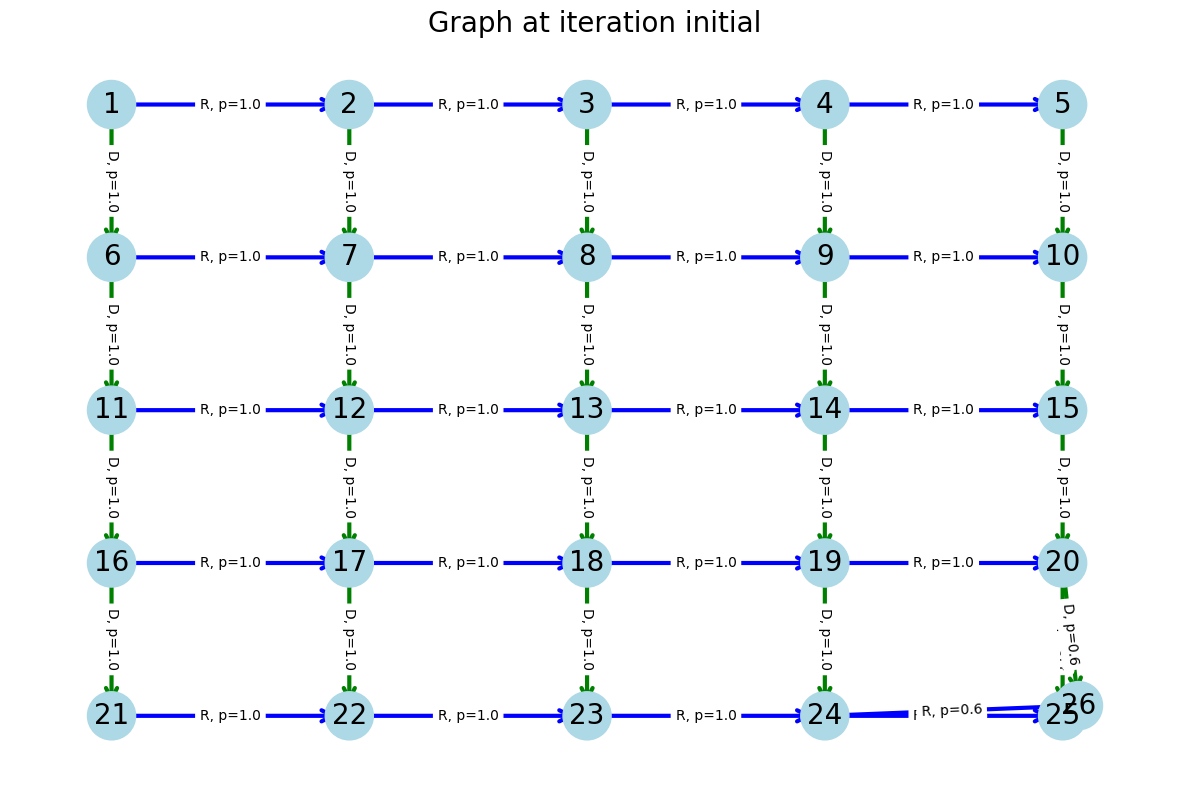

Iteration 0
[13, 25]
[13, 25]


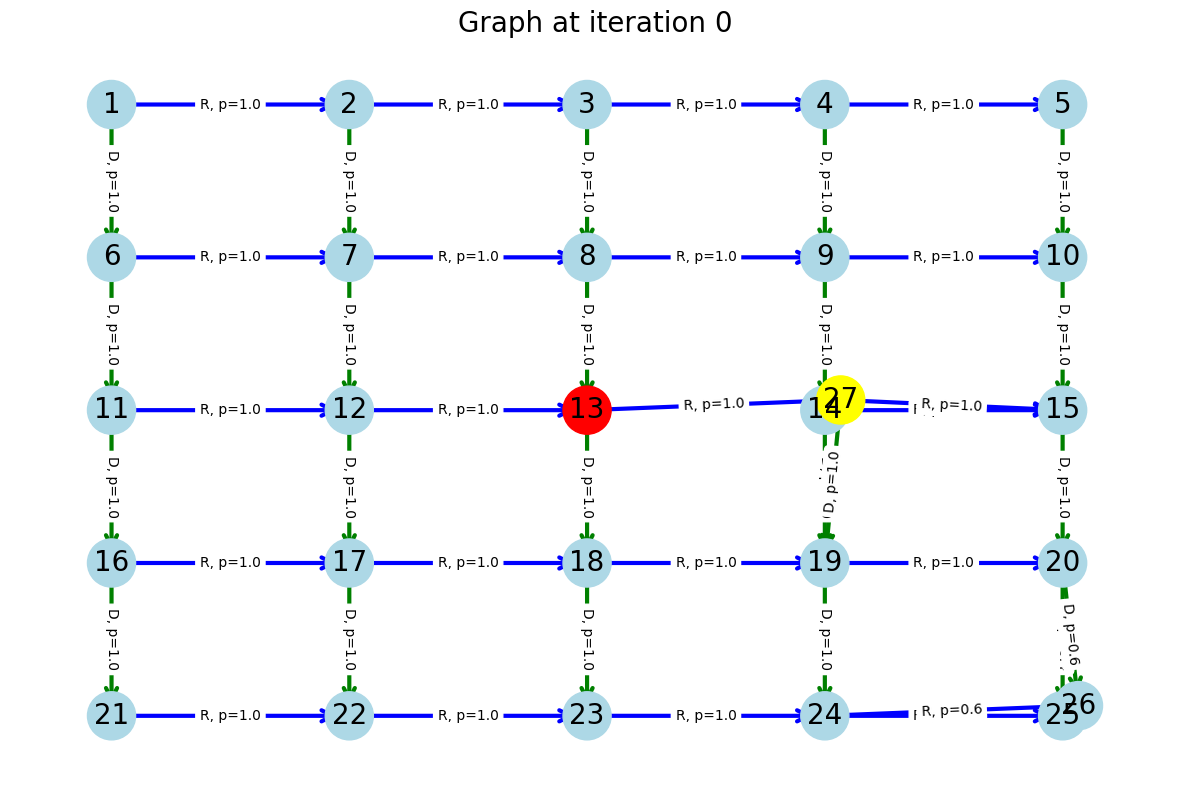

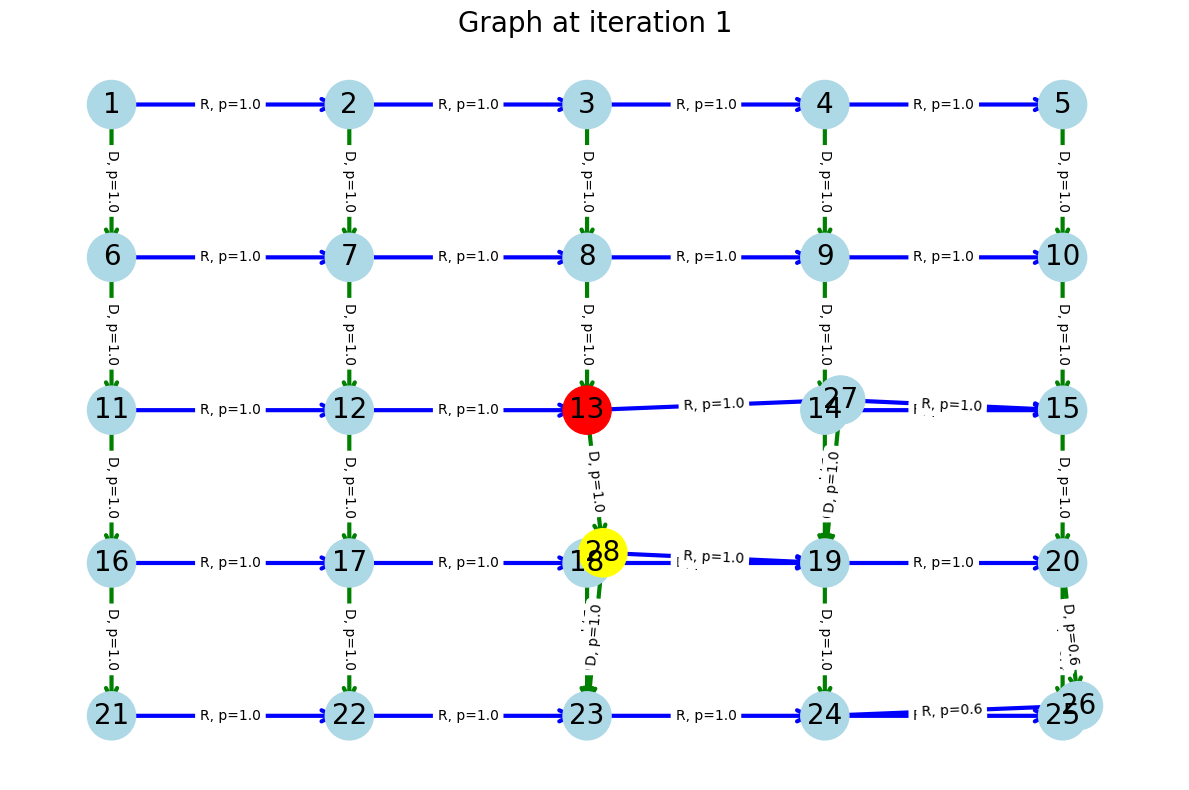



Iteration 1
[13, 25, 27, 28]
[13, 25, 27, 28]


Iteration 2
[13, 25, 27, 28]
[13, 25, 27, 28]


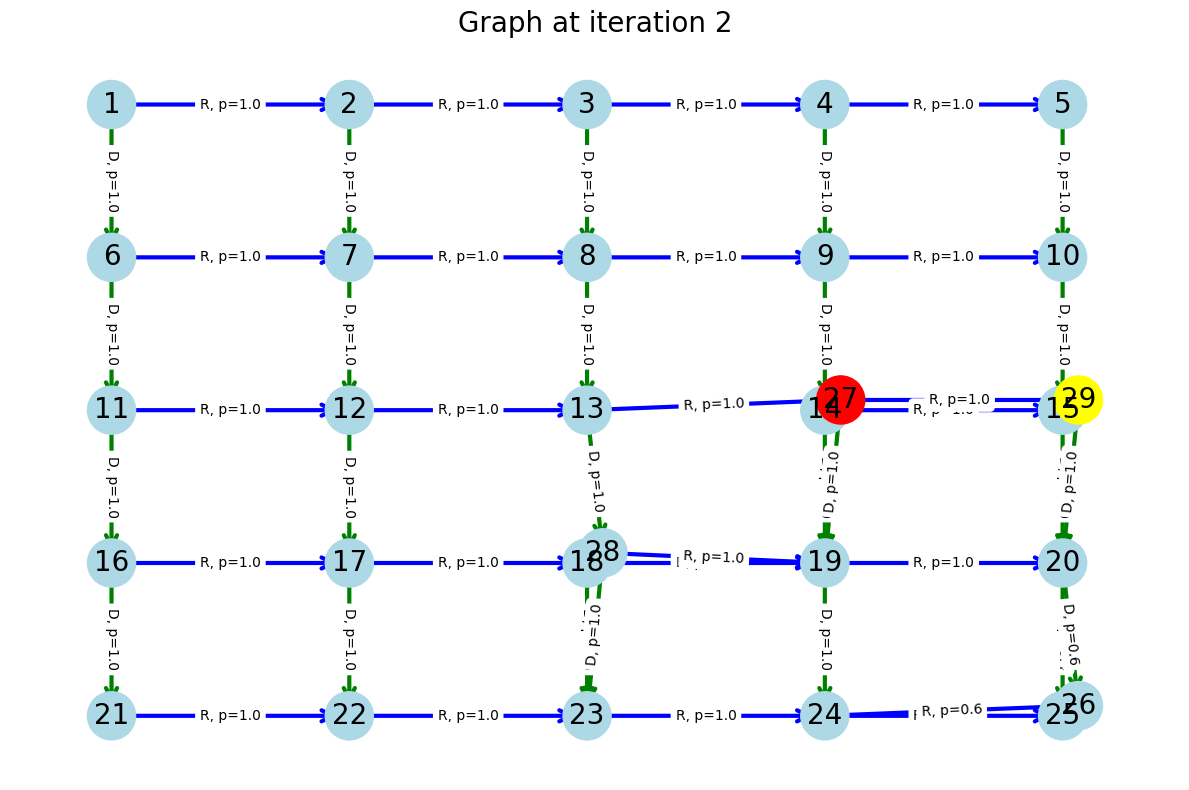

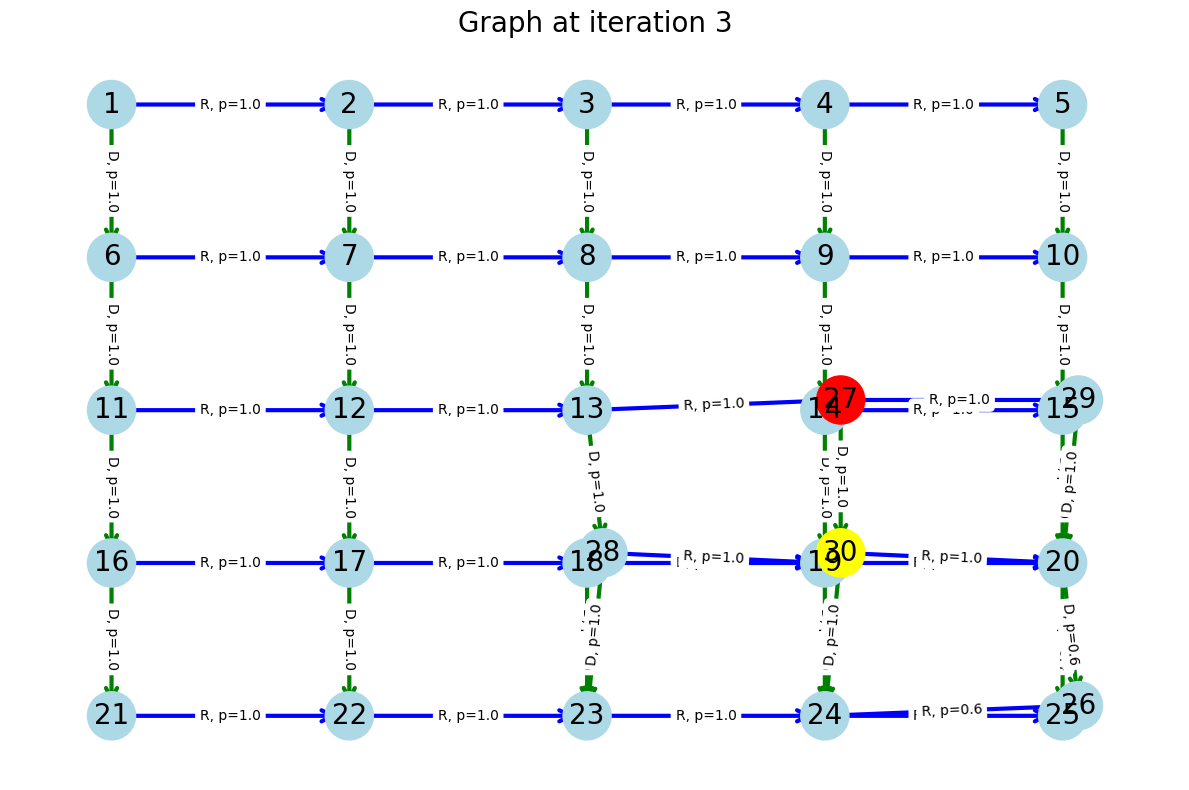



Iteration 3
[13, 25, 27, 28, 29, 30]
[13, 25, 27, 28, 30]


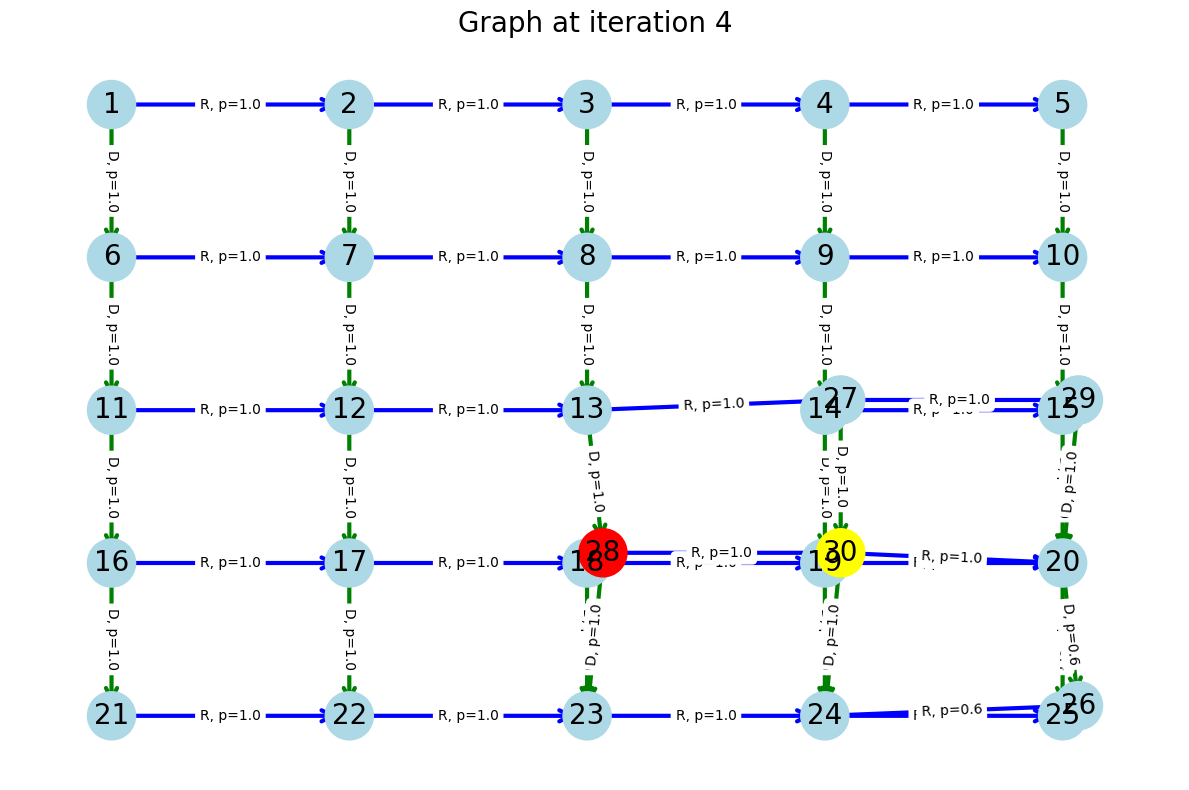

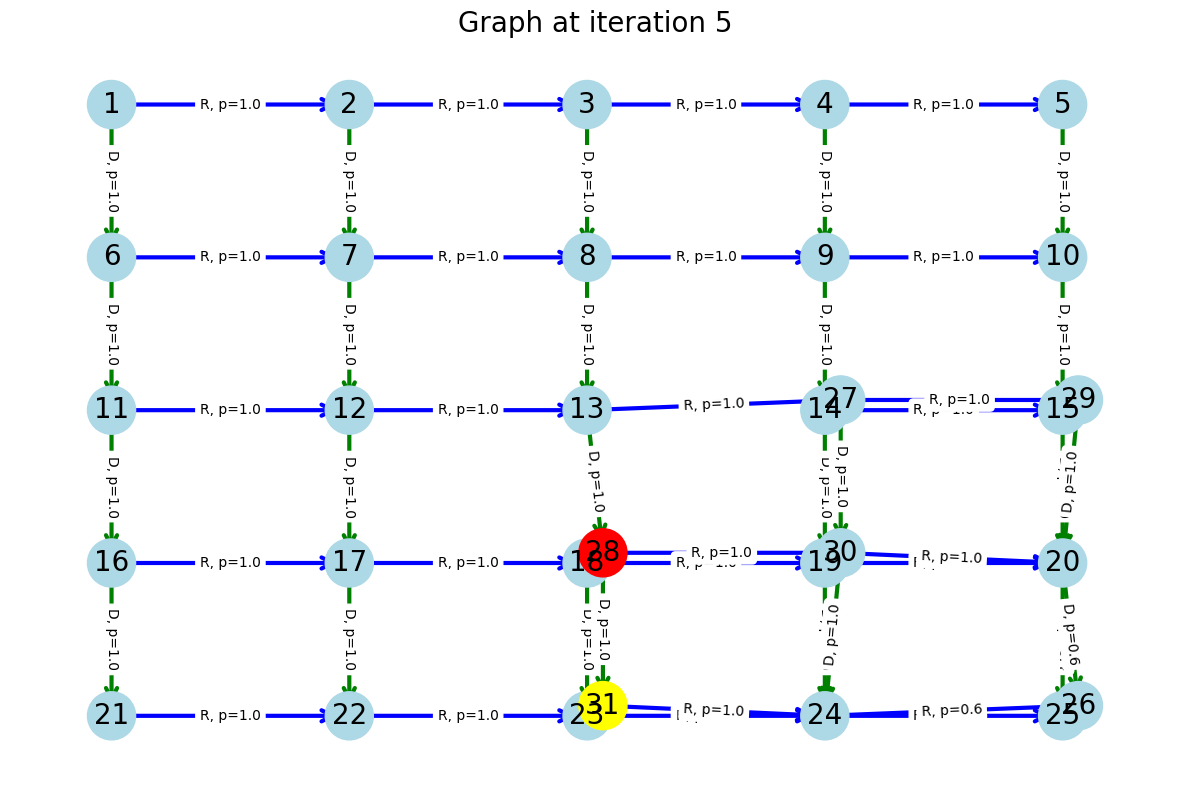



Iteration 4
[13, 25, 27, 28, 29, 30]
[13, 25, 27, 28, 30, 31]


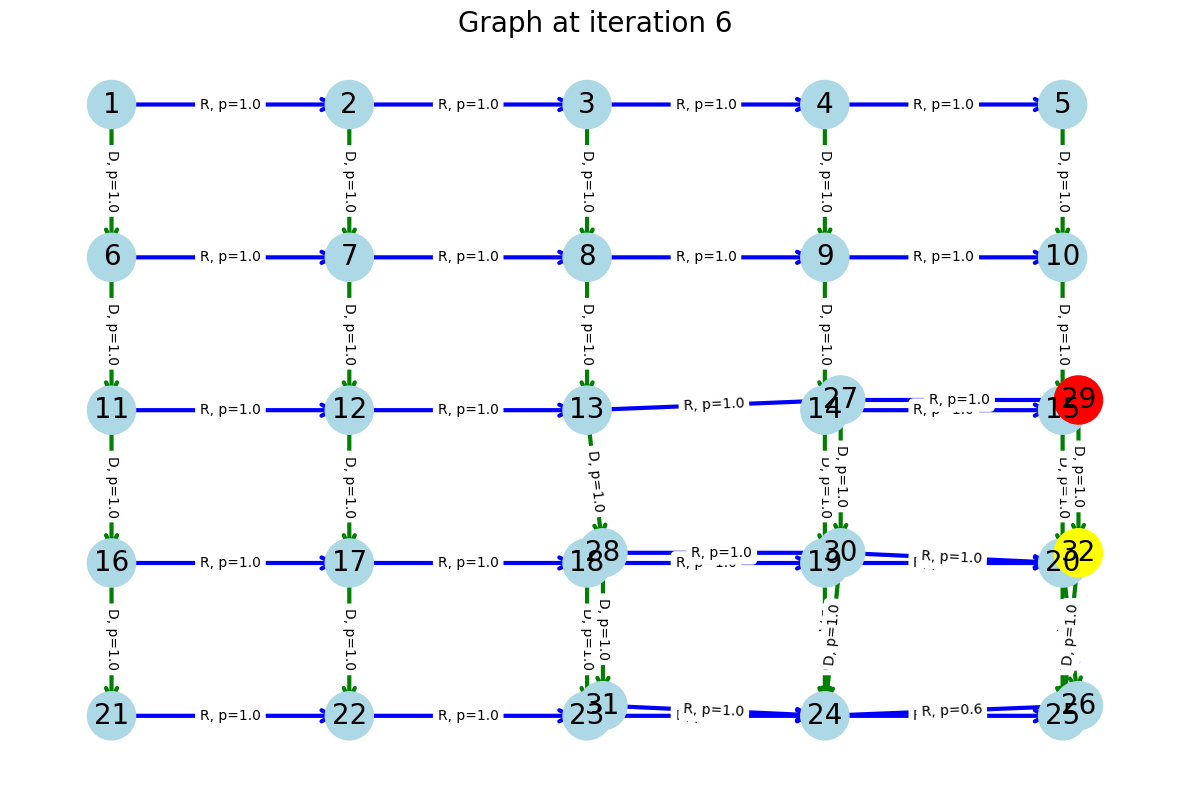



Iteration 5
[13, 25, 27, 28, 30]
[13, 25, 27, 28, 30, 31]


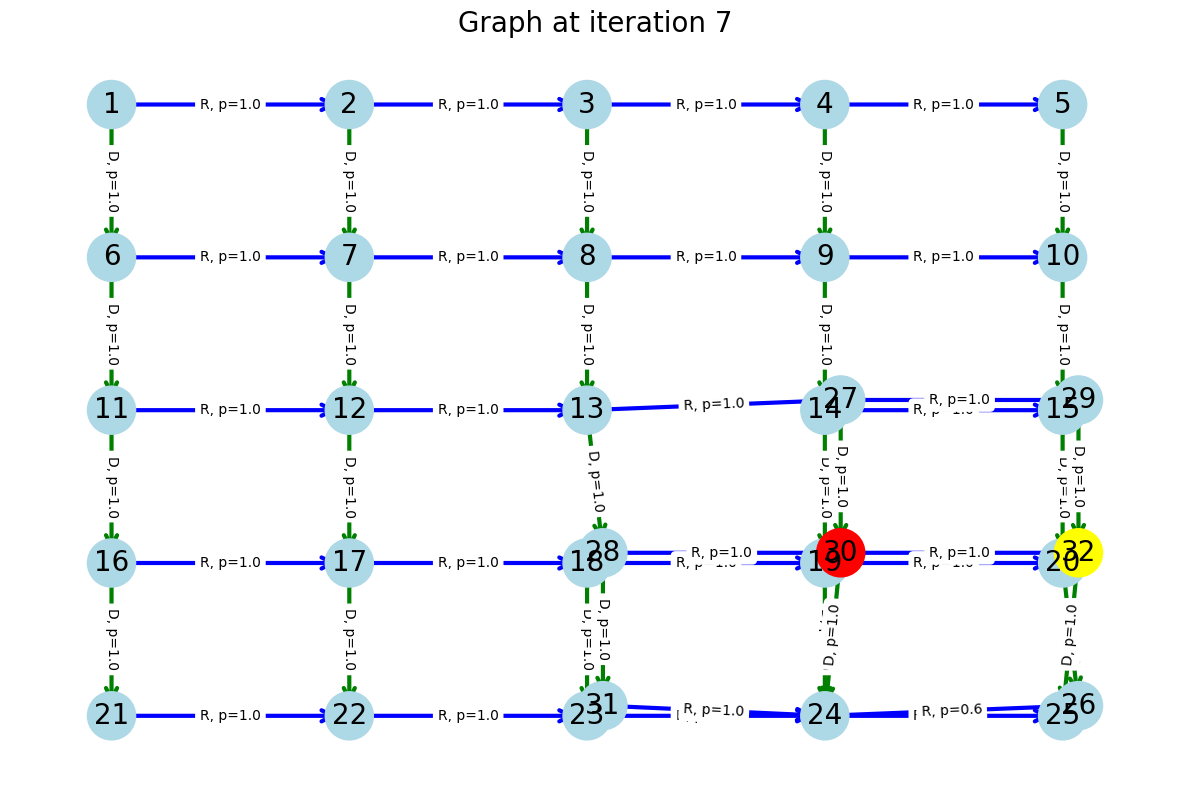

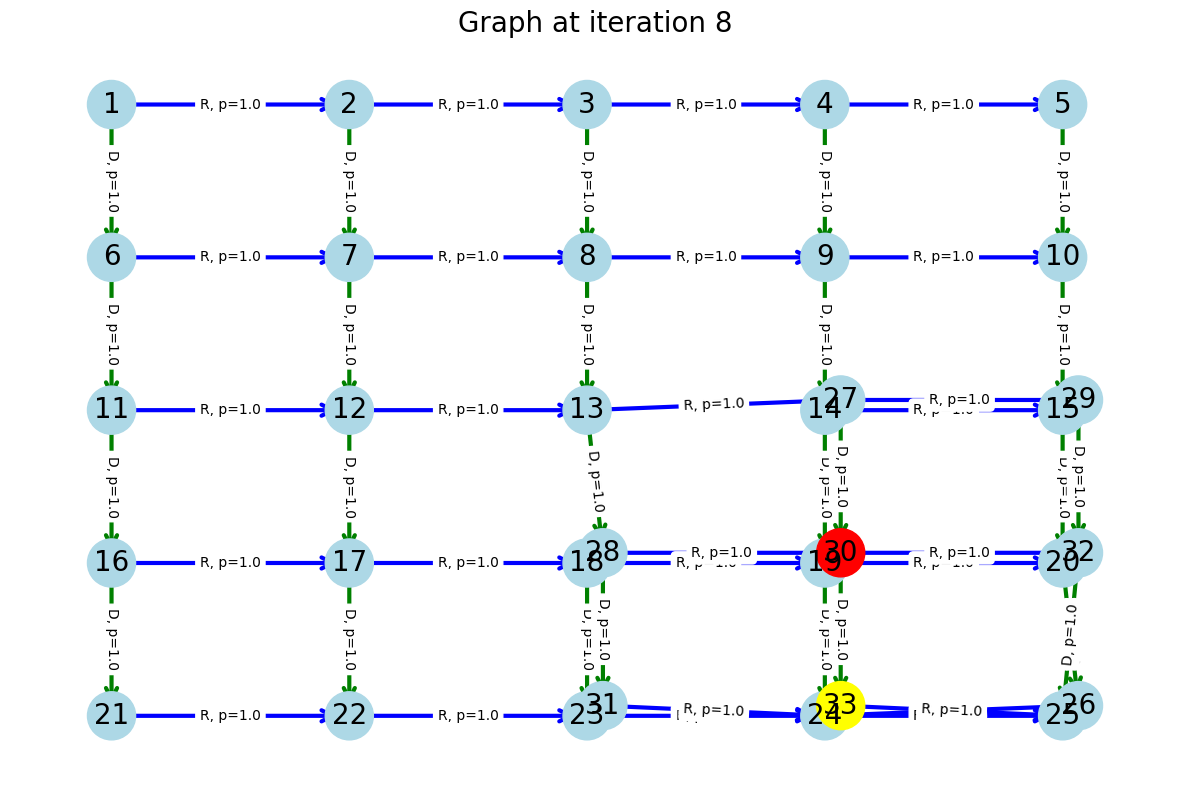



Iteration 6
[13, 25, 28, 31]


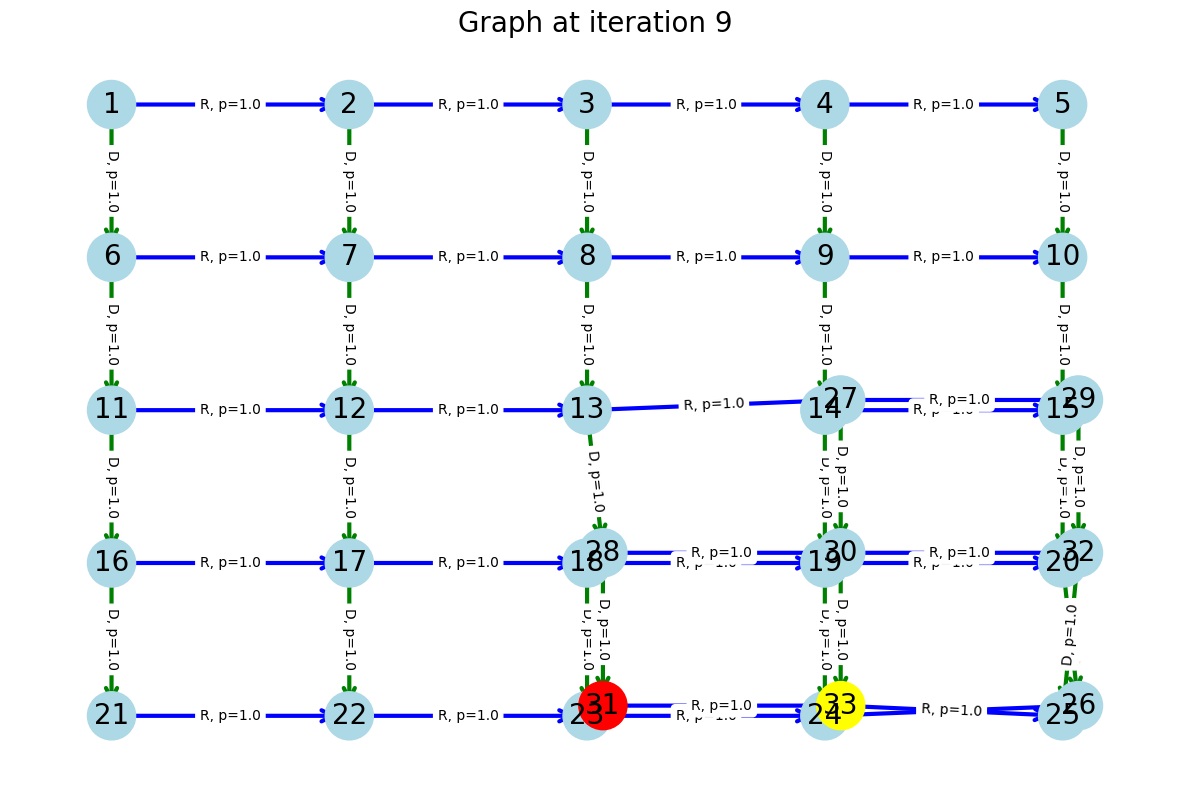



Iteration 7
Finished splitting at iteration 7


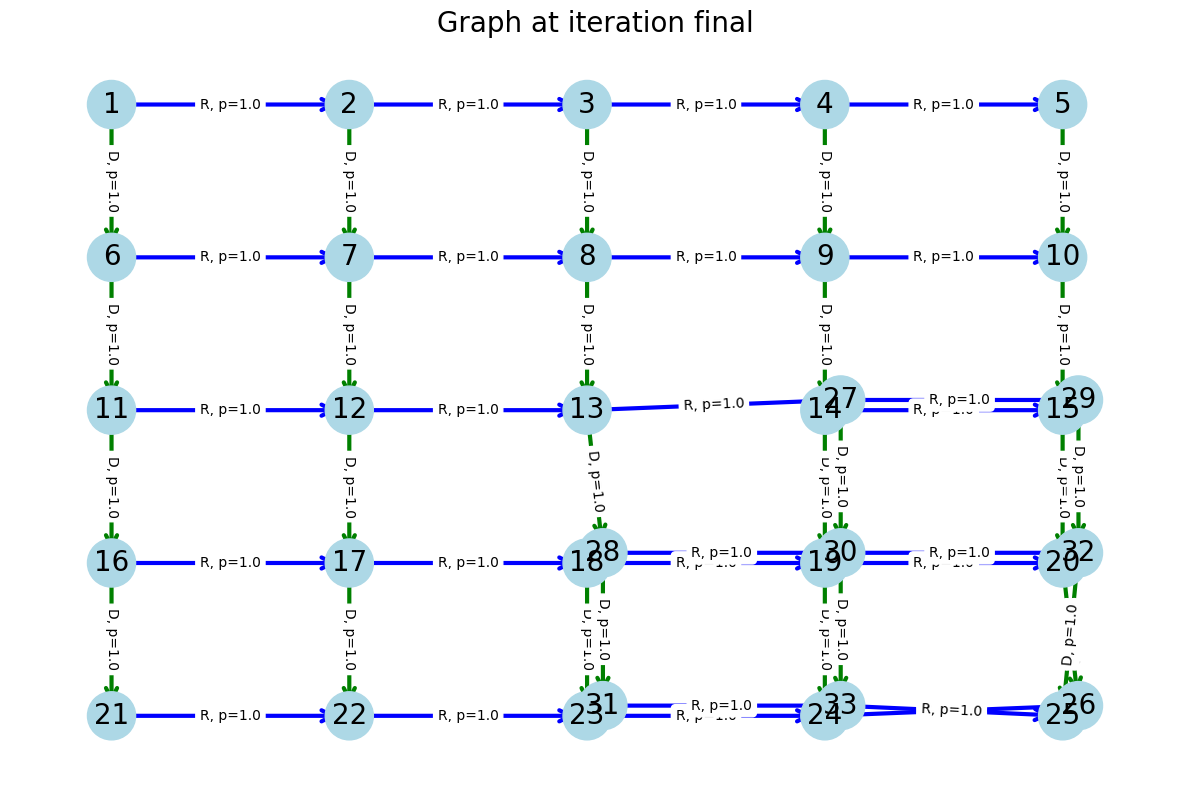

In [37]:
# Dataset
size = 5
env_size = (size,size)
rewarded_terminal = env_size[0]*env_size[1]
cue_states = [13]
env = GridEnvRightDownNoSelf(env_size=env_size, 
                             rewarded_terminal = [rewarded_terminal],
                             cue_states=cue_states)
# env = GridEnv(env_size=env_size, 
#                              rewarded_terminal = [rewarded_terminal],
#                              cue_states=cue_states)
# env = GridEnvRightDownNoSelf(cue_states=[6])

n_episodes = 1000
max_steps_per_episode = 100

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
transition_counts = transition_matrix_action(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=100
used_cues = []
# clone_map = []
# clone_dict = {} 
# reverse_clone_dict = {}
graphiter = 0
savename='cued'
env.plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    
    # compute SR
    
    
    
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            # print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            # if cue > env.num_unique_states:
            #     print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            # else:
            #     print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            if cue > env.num_unique_states: #17: # cloned state, so need to get the valid actions from the original state
                valid_actions = env.get_valid_actions(env.clone_dict[cue])
            else:
                valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in valid_actions:
                # print(cue,a)
                successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                # if reverse_clone_dict[successor]: # this has been created before
                if successor in env.reverse_clone_dict:
                    existing_clone = env.reverse_clone_dict[successor]
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                else:    # hasn't been created before. split        
                    # split this as a function of whether it came from cue (6) vs. others
                    # has_state(sequence,)
                    n_unique_states = len(get_unique_states(dataset))
                    new_clone = n_unique_states + 1            
                    
                    # clone_map.append((successor,new_clone))
                    env.add_clone_dict(new_clone, successor)
                    # clone_dict[new_clone] = successor
                    env.add_reverse_clone_dict(new_clone, successor)
                    # reverse_clone_dict[successor] = new_clone
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                # 2. modify transition count
                transition_counts = transition_matrix_action(dataset)
                denominators = transition_counts.sum(axis=2, keepdims=True)
                denominators[denominators == 0] = 1
                transition_probs = transition_counts / denominators
                # graphiter = 0
                env.plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
env.plot_graph(transition_probs,'final', savename=savename)    

[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.72       1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.5184     0.72       0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.  

ValueError: left cannot be >= right

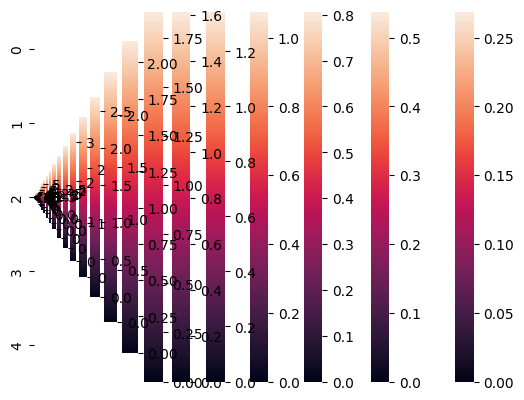

In [38]:
n_states = max(max(pair[0]) for pair in dataset) + 1
E_r = np.zeros((1,n_states))
E_nr = np.zeros((1,n_states))
for state_seq, _ in dataset:
    E = compute_eligibility_traces(state_seq, n_states)
    if state_seq[-1] == env_size[0]*env_size[1]:
        print(E)
        E_r += E[-1,:]
        # print(E_r)
        etmap = np.reshape(E_r[-1,:env_size[0]*env_size[1]], (env_size[0],env_size[1]))
        etmap = np.transpose(etmap)
        sns.heatmap(etmap) 
        # plt.show()       
        
    else: 
        E_nr += E[-1,:]
    #     print(E[-1,:])
    # print("Result: {}, cue: {}".format(state_seq[-1], E[-1,7]))
    # etmap = np.reshape(E[-1,:env_size[0]*env_size[1]], (env_size[0],env_size[1]))
    # etmap = np.transpose(etmap)
    # sns.heatmap(etmap)
    # plt.show()
    # sns.heatmap(E)
    # plt.show()

In [29]:
E

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.72      , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.     

In [41]:
E_r

array([[  0.        ,  11.98858866,   7.52295975,   3.06490953,
          0.        ,   0.        ,   9.12785783,  16.4390602 ,
         15.47934106,   0.        ,   0.        ,   3.62216581,
         16.64029164,  44.61060096,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 166.        ,   0.        ,  35.085312  ,
         26.873856  ,  24.3648    ,  41.472     ,  20.2176    ,
         64.08      ,  55.44      ]])

In [42]:
E_nr

array([[  0.        ,  21.01614037,  15.04591951,  12.39895219,
         11.22252227,   7.52467968,  14.14316434,  18.11082904,
         18.57520927,  33.86105856,  34.338816  ,  10.030613  ,
         17.22076692,   0.        ,  23.141376  ,  64.2816    ,
          9.28760463,  32.78610432,  25.007616  ,  36.288     ,
        115.2       ,   4.0310784 ,  26.12736   ,  50.2848    ,
         94.32      ,   0.        , 291.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]])

<Axes: >

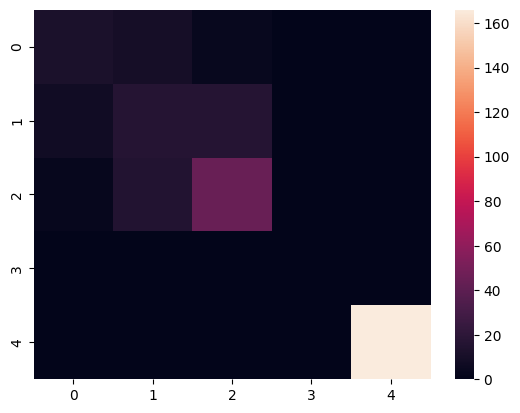

In [44]:
E_r_ = np.reshape(E_r[-1,1:env_size[0]*env_size[1]+1], (env_size[0],env_size[1]))
E_r_ = np.transpose(E_r_)
sns.heatmap(E_r_)

<Axes: >

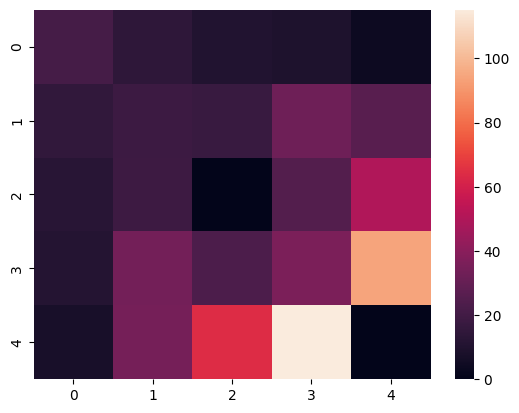

In [43]:
E_nr_ = np.reshape(E_nr[-1,1:env_size[0]*env_size[1]+1], (env_size[0],env_size[1]))
E_nr_ = np.transpose(E_nr_)
sns.heatmap(E_nr_)

<Axes: >

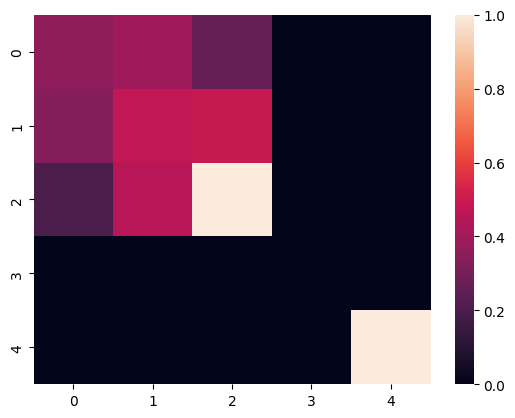

In [51]:
E_contingency = E_r_ / (E_r_ + E_nr_ )
sns.heatmap(E_contingency)

In [25]:

E = E_r * E_nr
E = np.reshape(E[1:env_size[0]*env_size[1]+1], (env_size[0],env_size[1]))

E = np.transpose(E)
sns.heatmap(E)

ValueError: cannot reshape array of size 0 into shape (5,5)

In [26]:
E

array([[   0.        , 1303.69146263,  659.01644193,    0.        ,
           0.        ,    0.        ,  597.31036807,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ]])

In [20]:
E

array([[   0.        , 1303.69146263,  659.01644193,    0.        ,
           0.        ,    0.        ,  597.31036807,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ]])

<Axes: >

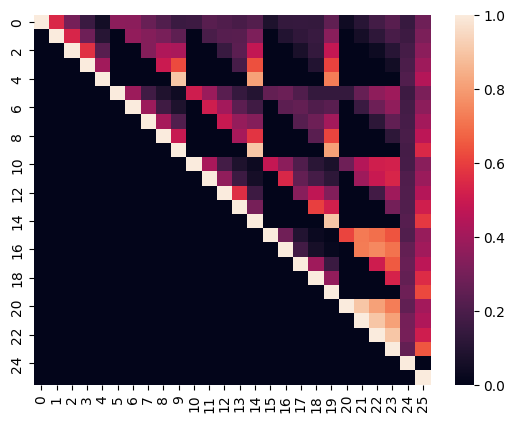

In [48]:
import seaborn as sns
dataset = generate_dataset(env, n_episodes, max_steps_per_episode)

sr = successor_representations(dataset, gamma=0.9, alpha=0.1, n_passes=5)

sns.heatmap(sr)

<Axes: >

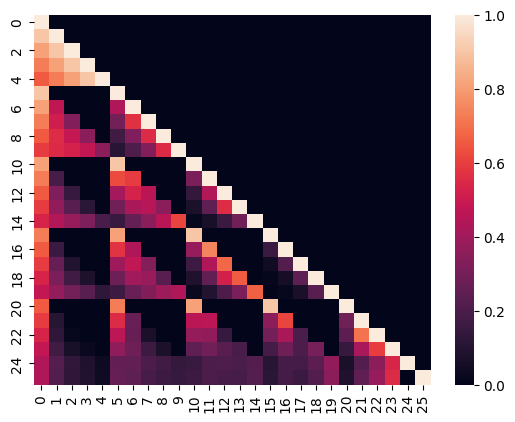

In [49]:
pr = predecessor_representations(dataset, gamma=0.9, alpha=0.1, n_passes=5)

sns.heatmap(pr)

In [ ]:
tol=1e-9
E_r = 
for s in range(np.shape(sr)[0]):
    dist = sr[s,:]
    p_nonzero = dist[dist > tol]
    
    # Normalize them so they sum to 1
    p_nonzero /= p_nonzero.sum()
    
    # Shannon entropy in bits
    #  E = - sum(p * log2(p))
    ent = -np.sum(p_nonzero * np.log2(p_nonzero))    
    print('Entropy for state {} is {}'.format(s,ent))

Entropy for state 0 is -0.0
Entropy for state 1 is 4.169676344681706
Entropy for state 2 is 3.9200241508159044
Entropy for state 3 is 3.4341825993891066
Entropy for state 4 is 2.813151437842775
Entropy for state 5 is 1.9898848740499775
Entropy for state 6 is 3.8314044898997475
Entropy for state 7 is 3.6326874535512634
Entropy for state 8 is 3.1817409271229513
Entropy for state 9 is 2.5563287329717768
Entropy for state 10 is 1.5796389004614042
Entropy for state 11 is -0.0
Entropy for state 12 is 3.2429796872371788
Entropy for state 13 is 2.7352488994888438
Entropy for state 14 is 2.137511956923073
Entropy for state 15 is 0.9980008838722993
Entropy for state 16 is 3.075034203874402
Entropy for state 17 is 2.571416232956773
Entropy for state 18 is 2.18465170174127
Entropy for state 19 is 1.4503480143416092
Entropy for state 20 is -0.0
Entropy for state 21 is -0.0
Entropy for state 22 is 1.5796389015423444
Entropy for state 23 is 0.9980008838722993
Entropy for state 24 is -0.0
Entropy for 

In [ ]:
np.unique(dataset[0][0])

array([ 1,  2,  8, 22, 23, 29, 30, 36, 39, 43, 47])

In [ ]:
dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
max(max(pair[0]) for pair in dataset)


26

In [ ]:
# # Functions for contingency & splitting

# def get_unique_states(dataset):
#     all_states = []
#     for states_seq, _ in dataset:
#         all_states.extend(states_seq)  # Flatten the list
#     unique_states = np.unique(all_states)
#     return unique_states

# def get_unique_states_from_env(env):
#     return [x for x in env.pos_to_state.values()]

# def has_state(sequence, state):
#     """Return True if the episode's state sequence contains state=5."""
#     return state in sequence

# def has_transition(s,sprime,sequence):
#     """Return True if the episode's state sequence contains a transition 15->16."""
#     for i in range(len(sequence) - 1):
#         if sequence[i] == s and sequence[i + 1] == sprime:
#             return True
#     return False

# # s=12
# # sprime=16
# # sprime2 = 17
# def calculate_contingency(dataset, s, sprime, sprime2):
#     unique_states = get_unique_states(dataset)
#     contingency_states = []
#     for curr_state in unique_states:
#         # if curr_state<100:
#         if (curr_state < s or curr_state > 17):    # maybe here
#             # print(curr_state)
#             # episodes_with_state = 0
#             # episodes_with_state_and_transition = 0
#             # other =0
#             # curr_state = 6

#             total = 0
#             a=0
#             b=0
#             c=0
#             d=0
#             conditioned_contingency=0
#             # print("Current state: {}".format(curr_state))
#             for states_seq, actions_seq in dataset:
#                 if has_state(states_seq,s):
#                     total += 1
#                     if has_state(states_seq, curr_state):
                    
                        
#                         # episodes_with_state += 1
#                         if has_transition(s,sprime,states_seq): 
#                             # episodes_with_state_and_transition += 1   
#                             a += 1
#                             # if curr_state==18:
#                             #     print('a:')
#                             #     print(states_seq)
#                             # print('transition: {}'.format(states_seq))
#                         elif has_transition(s,sprime2, states_seq): 
#                             # print(states_seq)
#                             b+=1
#                             # if curr_state==18:
#                             #     print('b:')
#                             #     print(states_seq)
#                     else: 
#                         # print('here')
#                         if has_transition(s,sprime,states_seq): 
#                             # episodes_with_state_and_transition += 1   
#                             c += 1
#                             # if curr_state==18:
#                             #     print('c:')
#                             #     print(states_seq)                            
                            
#                             # print('transition: {}'.format(states_seq))
#                         elif has_transition(s,sprime2, states_seq): 
#                             # print(states_seq)
#                             d+=1
#                             # if curr_state==18:
#                             #     print('d:')
#                             #     print(states_seq)                            
#                     assert total == a+b+c+d
#             # if curr_state == 18: 
#             #     print(a/(a+b), d/(c+d))
#             #     print(a,b,c,d)
#             # if a+b != 0: 
#             #     print("forward contingency: {}".format(a/(a+b)))
#             # else: 
#             #     print("no forward contingency")
#             # if c+d != 0: 
#             #     print("backward contingency: {}".format(d/(c+d)))
#             # else: 
#             #     print("no backward contingency")
#             if a+b !=0 and c+d != 0: 
#                 # if (a/(a+b)==1 and d/(c+d)==1):
#                 if a/(a+b)==1: # and d/(c+d)==1):
                    
#                     contingency_states.append(curr_state)
#         print(f"state {curr_state} has a value {a} and b value {b} leading to a/(a+b) = {a/(a+b) if a+b != 0 else -1}")
#         # print(f"state {curr_state} has a value {a} and c value {c} leading to a/(a+c) = {a/(a+c) if a+c != 0 else -1}")
        
#     print(f"contigency states: {contingency_states}")
#     return contingency_states

# def calculate_contingency_tmaze(dataset, s, sprime, sprime2):
#     unique_states = get_unique_states(dataset)
#     contingency_states = []
#     for curr_state in unique_states:
#         # if curr_state<100:
#         # if (curr_state < s or curr_state > 17):
#             # print(curr_state)
#             # episodes_with_state = 0
#             # episodes_with_state_and_transition = 0
#             # other =0
#             # curr_state = 6

#         total = 0
#         a=0
#         b=0
#         c=0
#         d=0
#         conditioned_contingency=0
#         # print("Current state: {}".format(curr_state))
#         for states_seq, actions_seq in dataset:
#             if has_state(states_seq,s):
#                 total += 1
#                 if has_state(states_seq, curr_state):
                
                    
#                     # episodes_with_state += 1
#                     if has_transition(s,sprime,states_seq): 
#                         # episodes_with_state_and_transition += 1   
#                         a += 1
#                         # if curr_state==18:
#                         #     print('a:')
#                         #     print(states_seq)
#                         # print('transition: {}'.format(states_seq))
#                     elif has_transition(s,sprime2, states_seq): 
#                         # print(states_seq)
#                         b+=1
#                         # if curr_state==18:
#                         #     print('b:')
#                         #     print(states_seq)
#                 else: 
#                     # print('here')
#                     if has_transition(s,sprime,states_seq): 
#                         # episodes_with_state_and_transition += 1   
#                         c += 1
#                         # if curr_state==18:
#                         #     print('c:')
#                         #     print(states_seq)                            
                        
#                         # print('transition: {}'.format(states_seq))
#                     elif has_transition(s,sprime2, states_seq): 
#                         # print(states_seq)
#                         d+=1
#                         # if curr_state==18:
#                         #     print('d:')
#                         #     print(states_seq)                            
#                 # assert total == a+b+c+d
#         # if curr_state == 18: 
#         #     print(a/(a+b), d/(c+d))
#         #     print(a,b,c,d)
#         # if a+b != 0: 
#         #     print("forward contingency: {}".format(a/(a+b)))
#         # else: 
#         #     print("no forward contingency")
#         # if c+d != 0: 
#         #     print("backward contingency: {}".format(d/(c+d)))
#         # else: 
#         #     print("no backward contingency")
#         if a+b !=0 and c+d != 0: 
#             # if (a/(a+b)==1 and d/(c+d)==1):
#             if a/(a+b)==1: # and d/(c+d)==1):
                
#                 contingency_states.append(curr_state)

#     return contingency_states

                
# def get_successor_states(transition_counts,s,a):
#     next_states = transition_counts[s,a]
#     sprime = np.where(next_states!=0)[0]
#     return sprime

In [176]:
np.shape(dataset[1][0])

(100,)

In [182]:
for i in range(len(dataset)):
    print(np.shape(dataset[i][0]), np.shape(dataset[i][1]))

(35,) (34,)
(100,) (100,)
(71,) (70,)
(79,) (78,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(57,) (56,)
(59,) (58,)
(15,) (14,)
(27,) (26,)
(100,) (100,)
(100,) (100,)
(87,) (86,)
(23,) (22,)
(49,) (48,)
(100,) (100,)
(100,) (100,)
(35,) (34,)
(100,) (100,)
(21,) (20,)
(25,) (24,)
(49,) (48,)
(100,) (100,)
(89,) (88,)
(85,) (84,)
(29,) (28,)
(39,) (38,)
(69,) (68,)
(79,) (78,)
(55,) (54,)
(49,) (48,)
(87,) (86,)
(100,) (100,)
(100,) (100,)
(43,) (42,)
(33,) (32,)
(100,) (100,)
(87,) (86,)
(53,) (52,)
(61,) (60,)
(100,) (100,)
(100,) (100,)
(75,) (74,)
(55,) (54,)
(11,) (10,)
(17,) (16,)
(29,) (28,)
(23,) (22,)
(77,) (76,)
(69,) (68,)
(39,) (38,)
(100,) (100,)
(43,) (42,)
(100,) (100,)
(100,) (100,)
(23,) (22,)
(100,) (100,)
(37,) (36,)
(23,) (22,)
(67,) (66,)
(63,) (62,)
(13,) (12,)
(53,) (52,)
(23,) (22,)
(11,) (10,)
(100,) (100,)
(75,) (74,)
(91,) (90,)
(11,) (10,)
(100,) (100,)
(100,) (100,)
(51,) (50,)
(55,) (54,)
(19,) (18,)
(59,) (58,)
(41,) (40,)
(100,) (100,)
(65,) (64,)
(100,)

In [9]:
# Dataset
env = GridEnvDivergingSingleReward(cue_state=6)

n_episodes = 500
max_steps_per_episode = 10

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
transition_counts = transition_matrix_action(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=10
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='cued'
plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    # figure out which transitions are highly stochastic
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            tmp = get_successor_states(transition_counts,s,a)
            print(tmp)
            sprime, sprime2 = tmp

            print(f"successor states: {sprime}, {sprime2}")

            cue = calculate_contingency(dataset, s, sprime, sprime2)
            # print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 17:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            if cue > 17: # cloned state, so need to get the valid actions from the original state
                valid_actions = env.get_valid_actions(clone_dict[cue])
            else:
                valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in valid_actions:
                # print(cue,a)
                successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                print(f"successor of cue {cue} is {successor}")
                # if reverse_clone_dict[successor]: # this has been created before
                if successor in reverse_clone_dict and reverse_clone_dict:
                    existing_clone = reverse_clone_dict[successor]
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                else:    # hasn't been created before. split        
                    # split this as a function of whether it came from cue (6) vs. others
                    # has_state(sequence,)
                    print(2)
                    n_unique_states = env.num_unique_states
                    new_clone = n_unique_states + 1   

                    # update the num of new states
                    env.num_unique_states = new_clone

                    print(f"new clone {new_clone} created")         
                    
                    # clone_map.append((successor,new_clone))
                    clone_dict[new_clone] = successor
                    reverse_clone_dict[successor] = new_clone
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                # 2. modify transition count
                transition_counts =transition_matrix_action(dataset)
                denominators = transition_counts.sum(axis=2, keepdims=True)
                denominators[denominators == 0] = 1
                transition_probs = transition_counts / denominators
                # graphiter = 0
                plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
plot_graph(transition_probs,'final', savename=savename)    

NameError: name 'GridEnvDivergingSingleReward' is not defined

# Dataset with no cue (just stochastic transition to 16 or 17)


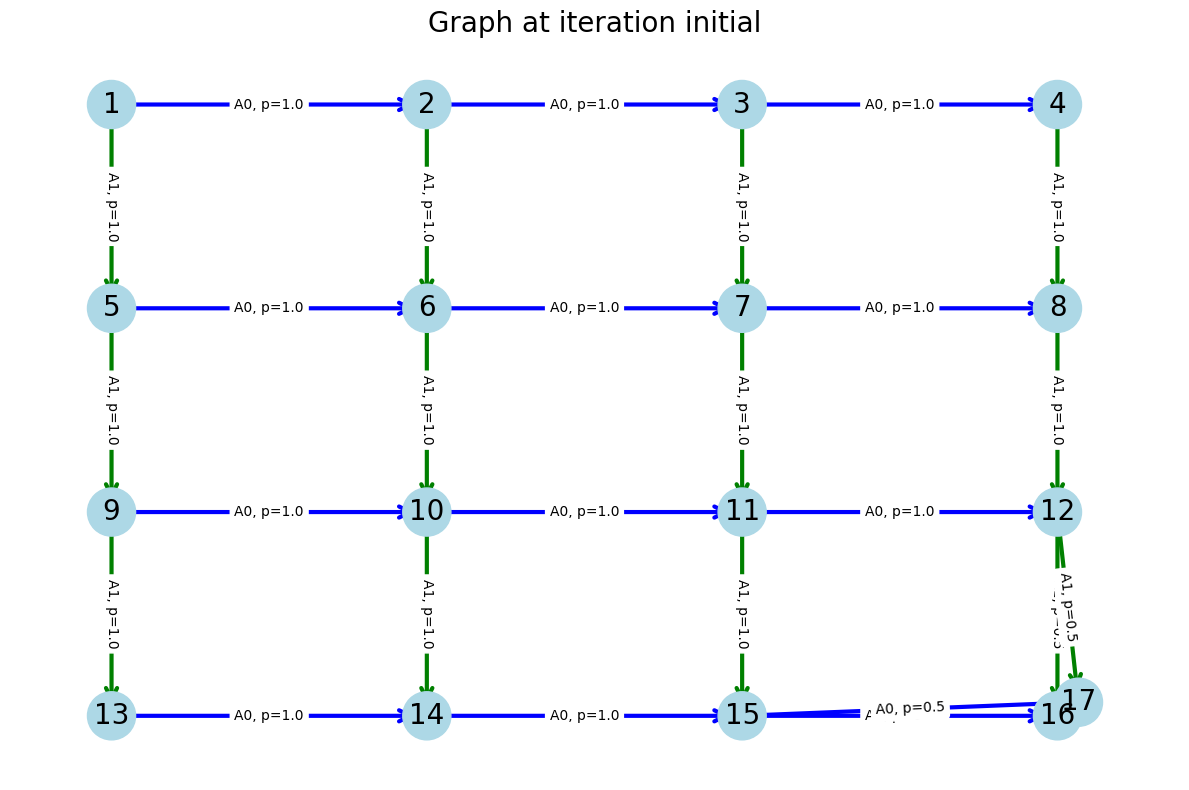

Iteration 0
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 1
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 2
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 3
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 4
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 5
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 6
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 7
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 8
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 9
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]




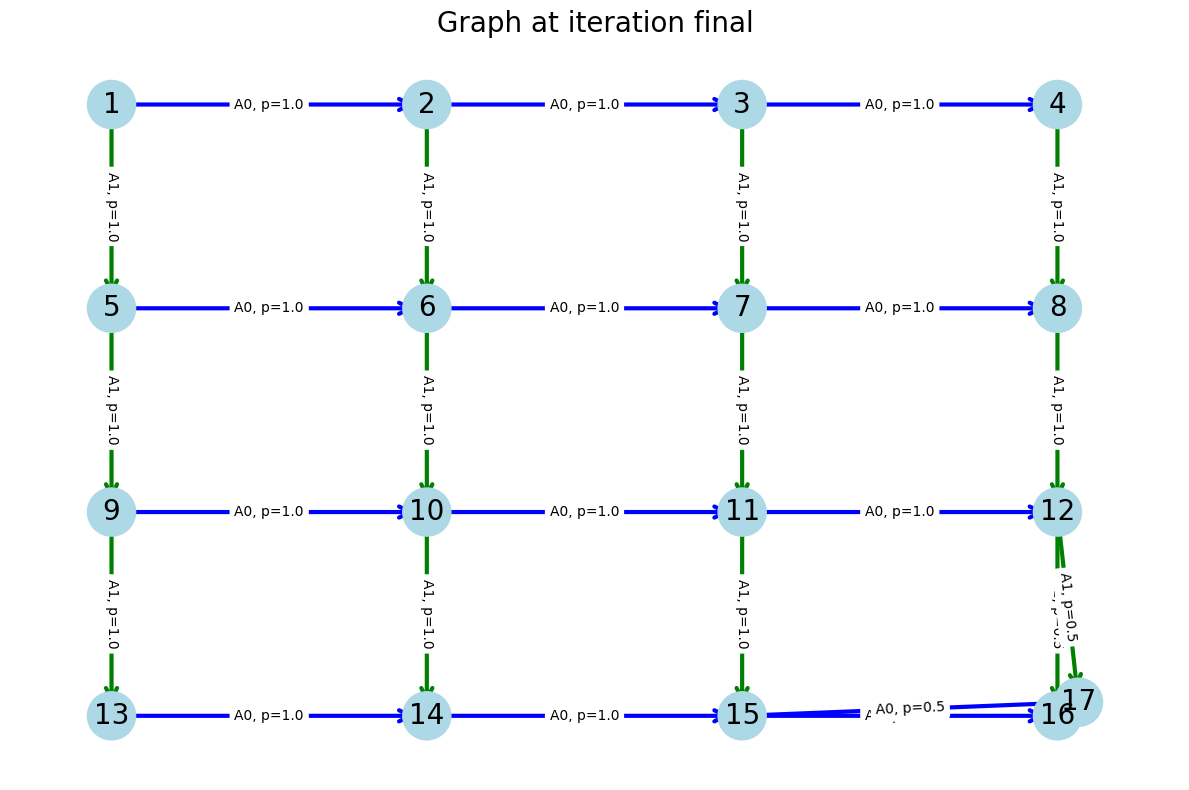

In [34]:
# Dataset
env = GridEnvRightDownNoCue()

n_episodes = 500
max_steps_per_episode = 10

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
transition_counts = transition_matrix_action(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=10
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename = 'nocue'
plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 17:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            if cue > 17: # cloned state, so need to get the valid actions from the original state
                valid_actions = env.get_valid_actions(clone_dict[cue])
            else:
                valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in valid_actions:
                # print(cue,a)
                successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                # if reverse_clone_dict[successor]: # this has been created before
                if successor in reverse_clone_dict:
                    existing_clone = reverse_clone_dict[successor]
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                else:    # hasn't been created before. split        
                    # split this as a function of whether it came from cue (6) vs. others
                    # has_state(sequence,)
                    n_unique_states = len(get_unique_states(dataset))
                    new_clone = n_unique_states + 1            
                    
                    # clone_map.append((successor,new_clone))
                    clone_dict[new_clone] = successor
                    reverse_clone_dict[successor] = new_clone
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                # 2. modify transition count
                transition_counts = transition_matrix_action(dataset)
                denominators = transition_counts.sum(axis=2, keepdims=True)
                denominators[denominators == 0] = 1
                transition_probs = transition_counts / denominators
                # graphiter = 0
                plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
plot_graph(transition_probs,'final',savename=savename)    

# Splitter cell experiment

In [8]:
def plot_graph_nogrid(T, niter, highlight_node=0, highlight_node_2=0, save=True, savename='nogrid'):
    # plot_graph_nogrid(transition_probs,graphiter, cue, new_clone,savename=savename)
    # transition_probs,graphiter, cue, new_clone,savename=savename
    n_state = np.shape(T)[0]
    n_action = np.shape(T)[1]
    # T = np.random.rand(n_state, n_action, n_state)
    # Normalize so that each [s,a,:] sums to 1 (like proper probabilities)
    # for s in range(n_state):
    #     for a in range(n_action):
    #         T[s, a, :] /= T[s, a, :].sum()

    # Initialize a directed graph
    G = nx.DiGraph()

    # Add edges
    for s in range(n_state):
        for a in range(n_action):
            for s_next in range(n_state):
                prob = T[s, a, s_next]
                if prob > 0:
                    # You can store an edge label that contains the action 
                    # and probability.
                    G.add_edge(
                        f"{s}", f"{s_next}", 
                        label=f"A{a}, p={prob:.2f}"
                    )
    # Create a color list; default 'lightblue', but 'red' for special_node
    colors = []
    for node in G.nodes():
        if node == highlight_node:
            colors.append("red")
        elif node == highlight_node_2:
            colors.append("yellow")
        else:
            colors.append("lightblue")
    # Layout the graph
    pos = nx.shell_layout(G)  # you can choose any layout

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=colors)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis('off')
    plt.title("Iteration {}".format(niter))
    plt.show()


In [50]:
np.shape(transition_probs)[1]

2

In [ ]:
# TODO: Talking points
# - why is there a random extra one?
# - how should the paths for continuous T-Maze be generated - just stop at a certain length or once there is a rewward?
# - should the cue's randomly change for the continuous T-Maze?


In [16]:
def generate_CT_walks(model:ContinuousTMaze, num_observations:int=100) -> list:
    """Function that returns a list of observed states with debugging info"""
    dataset = []
    start_end_pairs = []  # Keep track of start/end pairs

    for i in range(num_observations):
        model.reset()
        start_state = model.current_state
        states = [model.current_state]
        actions = []

        while model.running:
            valid_actions = model.get_valid_actions(model.current_state)
            if not valid_actions:
                break
                
            action = random.choice(valid_actions)
            model.step(action)

            actions.append(action)
            states.append(model.current_state)
        
        end_state = states[-1]
        start_end_pairs.append((start_state, end_state))
        states.append(states[0])  # add the starting state to the end
        dataset.append([states, actions])
        
        # Print debugging info every 10 walks
        if i % 10 == 0:
            print(f"Walk {i}:")
            print(f"  Start state: {start_state}")
            print(f"  Path: {states}")
            print(f"  End state: {end_state}")
            print()

    # Print summary statistics
    print("\nSummary of start/end state pairs:")
    from collections import Counter
    pair_counts = Counter(start_end_pairs)
    for pair, count in pair_counts.items():
        print(f"Start: {pair[0]} -> End: {pair[1]}: {count} times")
    
    return dataset

# TODO: CHECK TO SEE IF ITS THE ALTERNATING TMAZE OR JUST RANDOM

<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
/var/folders/k_/22wd5tt52nqbzmr9k7yzq1xm0000gn/T/ipykernel_52864/466051842.py:2: SyntaxWarning: invalid escape sequence '\ '
  """


Walk 0:
  Start state: 2
  Path: [2, 3, 6, 2]
  End state: 6

Walk 10:
  Start state: 2
  Path: [2, 3, 5, 2]
  End state: 5

Walk 20:
  Start state: 1
  Path: [1, 3, 4, 1]
  End state: 4

Walk 30:
  Start state: 1
  Path: [1, 3, 7, 1]
  End state: 7

Walk 40:
  Start state: 2
  Path: [2, 3, 5, 2]
  End state: 5

Walk 50:
  Start state: 2
  Path: [2, 3, 6, 2]
  End state: 6

Walk 60:
  Start state: 1
  Path: [1, 3, 4, 1]
  End state: 4

Walk 70:
  Start state: 2
  Path: [2, 3, 6, 2]
  End state: 6

Walk 80:
  Start state: 2
  Path: [2, 3, 5, 2]
  End state: 5

Walk 90:
  Start state: 2
  Path: [2, 3, 6, 2]
  End state: 6


Summary of start/end state pairs:
Start: 2 -> End: 6: 23 times
Start: 1 -> End: 7: 27 times
Start: 1 -> End: 4: 22 times
Start: 2 -> End: 5: 28 times
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfguowf
sdfjhasodfgu

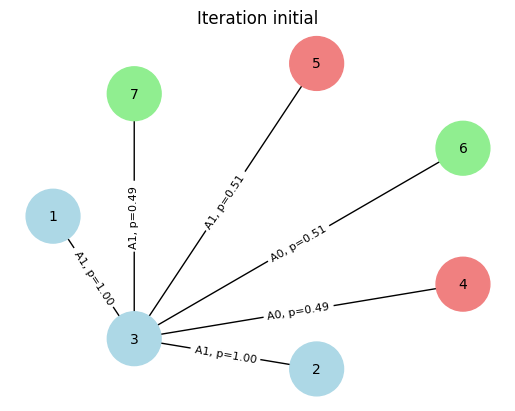

Iteration 0
Stochastic pairs: (3, 0)
[np.int64(1), np.int64(4)]
Stochastic pairs: (3, 1)
[np.int64(2), np.int64(5)]
[1 2 4 5]
Current cue: 1


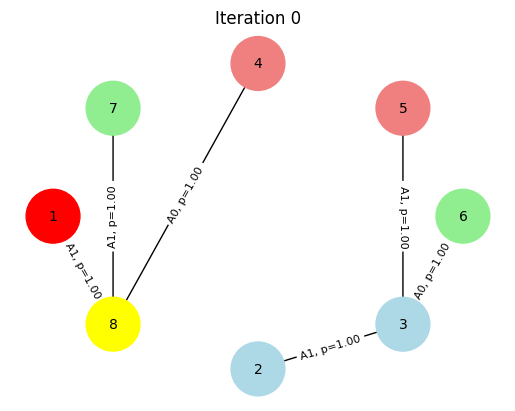



Iteration 1
Finished splitting at iteration 1


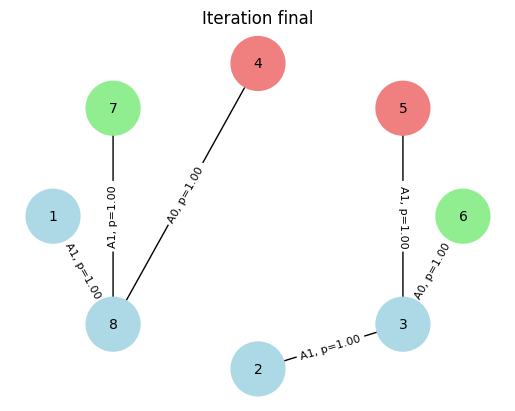

In [17]:
env = ContinuousTMaze()

dataset = generate_CT_walks(env, 100)

for x, _ in dataset:
    if 5 in x:
        print("sdfjhasodfguowf")

transition_counts = transition_matrix_action(dataset)

denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=20
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='ctmaze'
env.plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency_tmaze(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        print(unique_cues)
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 6:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            # if cue > 6: # cloned state, so need to get the valid actions from the original state
            #     valid_actions = env.get_valid_actions(clone_dict[cue])
            # else:
            #     valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in actions:
                # print(cue,a)
                if get_successor_states(transition_counts,cue,a).size>0:
                    successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                    # if reverse_clone_dict[successor]: # this has been created before
                    if successor in reverse_clone_dict:
                        existing_clone = reverse_clone_dict[successor]
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                    else:    # hasn't been created before. split        
                        # split this as a function of whether it came from cue (6) vs. others
                        # has_state(sequence,)
                        n_unique_states = len(get_unique_states(dataset))
                        new_clone = n_unique_states + 1            
                        
                        # clone_map.append((successor,new_clone))
                        clone_dict[new_clone] = successor
                        reverse_clone_dict[successor] = new_clone
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                    # 2. modify transition count
                    transition_counts = transition_matrix_action(dataset)
                    denominators = transition_counts.sum(axis=2, keepdims=True)
                    denominators[denominators == 0] = 1
                    transition_probs = transition_counts / denominators
                    # graphiter = 0
                    env.plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                    graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
env.plot_graph(transition_probs,'final', savename=savename)

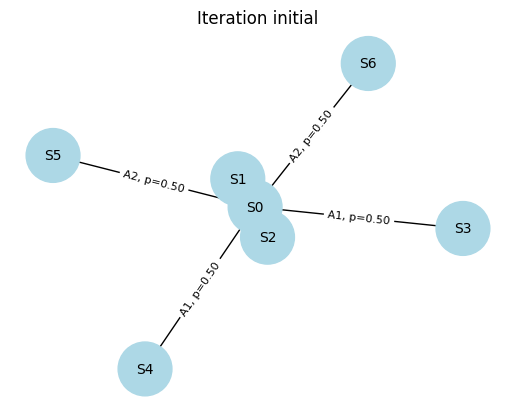

Iteration 0
Stochastic pairs: (0, 1)
[np.int64(1), np.int64(3)]
Stochastic pairs: (0, 2)
[np.int64(2), np.int64(5)]
[1 2 3 5]
Current cue: 1


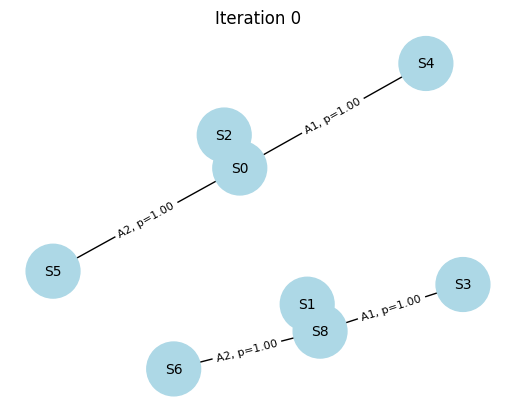



Iteration 1
Finished splitting at iteration 1


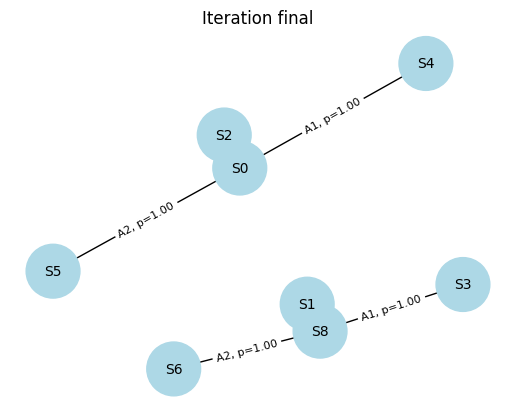

In [39]:
observation_1 = [1,0,3] # start 1, left turn, rewarded
observation_2 = [2,0,5] # start 2, right turn, rewarded
observation_3 = [1,0,6] # start 1, right turn, no reward
observation_4 = [2,0,4] # start 2, left turn, no reward
# 2: left turn, 4: right turn, 5: reward, 6: no reward
actions_1 = [0,1]
actions_2 = [0,2]
actions_3 = [0,2]
actions_4 = [0,1]
n_data = 100 #25
super_observations = np.array(([observation_1] * n_data) +
                          ([observation_2] * n_data) +
                          ([observation_3] * n_data) +
                          ([observation_4] * n_data))
# np.random.shuffle(super_observations)
# Build super_actions with the same structure
super_actions = np.array(([actions_1] * n_data) +
                         ([actions_2] * n_data) +
                         ([actions_3] * n_data) +
                         ([actions_4] * n_data))

# We now have 100 rows in each (25 x 4 = 100).
# Shuffle them in the *same* order using a random permutation of indices
permutation = np.random.permutation(len(super_observations))

# Apply the permutation to both arrays
super_observations = super_observations[permutation]
super_actions = super_actions[permutation]
dataset=[]
for l in range(len(super_observations)):
    dataset.append([super_observations[l], super_actions[l]])



transition_counts = transition_matrix_action(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1,2]
iterations=20
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='tmaze'
plot_graph_nogrid(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency_tmaze(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        print(unique_cues)
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 6:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            # if cue > 6: # cloned state, so need to get the valid actions from the original state
            #     valid_actions = env.get_valid_actions(clone_dict[cue])
            # else:
            #     valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in actions:
                # print(cue,a)
                if get_successor_states(transition_counts,cue,a).size>0:
                    successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                    # if reverse_clone_dict[successor]: # this has been created before
                    if successor in reverse_clone_dict:
                        existing_clone = reverse_clone_dict[successor]
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                    else:    # hasn't been created before. split        
                        # split this as a function of whether it came from cue (6) vs. others
                        # has_state(sequence,)
                        n_unique_states = len(get_unique_states(dataset))
                        new_clone = n_unique_states + 1            
                        
                        # clone_map.append((successor,new_clone))
                        clone_dict[new_clone] = successor
                        reverse_clone_dict[successor] = new_clone
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                    # 2. modify transition count
                    transition_counts = transition_matrix_action(dataset)
                    denominators = transition_counts.sum(axis=2, keepdims=True)
                    denominators[denominators == 0] = 1
                    transition_probs = transition_counts / denominators
                    # graphiter = 0
                    plot_graph_nogrid(transition_probs,graphiter, cue, new_clone,savename=savename)
                    graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
plot_graph_nogrid(transition_probs,'final', savename=savename)    

In [69]:
get_successor_states(transition_counts,cue,a)

array([0])

In [64]:
transition_counts[4,0]

array([  0,   0,   0,   0,   0, 100, 100,   0,   0])

In [82]:
get_successor_states(transition_counts,1,0)

array([0])